**<h1><center>Deep Learning Systems (ENGR-E 533) 
<br>Homework 3 , Fall 2021</h1>**

**Name: Anitha Ganapathy** <br>
**Email: aganapa@iu.edu** <br>


___

## Problem 3: Speech Denoising Using RNN

### Organizing Imports


In [ ]:
!pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 5.3 MB/s 


In [ ]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers import LSTM
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.layers import Rescaling
from keras.layers import BatchNormalization
from keras.utils import np_utils
from tensorflow.keras import initializers

from keras.datasets import cifar10
import tensorflow_addons as tfa

import time
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


# for Problem 3
import soundfile as sf
import IPython.display as ipd
from math import ceil
import pickle
import glob
import librosa
import copy
import soundfile as sf
import IPython.display as ipd

import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

from google.colab import drive

drive.mount('/content/drive' ,force_remount =  True)  

Mounted at /content/drive


- **trx0000.wav to trx0009.wav :** are all saying the same
sentence spoken by the same person, while they are contaminated by different noise signals. <br>
- **trs0000.wav to trs1199.wav :** the original clean speech <br> 
- **trn0000.wav to trn1199.wav :** noise sources

In [ ]:
!ls '/content/drive/MyDrive/data/timit-homework'

te			   train_noise_lists_pkl.pkl  val_noise_lists_pkl.pkl
test_sound_lists_pkl.pkl   train_sound_lists_pkl.pkl  val_sound_lists_pkl.pkl
tr			   v
train_clean_lists_pkl.pkl  val_clean_lists_pkl.pkl


In [ ]:
dirpath = '/content/drive/MyDrive/data/timit-homework/'

### Helper function to read and transform sound files.

In [ ]:
def file_op(file):
  #Loading train files
  
  s,sr=librosa.load(file, sr=None)
  S=librosa.stft(s, n_fft=1024, hop_length=512)
  
  #Taking absolute of input and output of training file
  S =  S.T
  S_abs = np.abs(S)
  
  #print(S_abs.shape)
  
  return s, S, S_abs

In [ ]:
def load_files(filepath):
  
  at_list = []
  spec_list = []
  spec_abs_list = []
  
  print(dirpath+filepath)
  
  for file in sorted(glob.glob(dirpath+filepath)):
    at, spec, spec_abs = file_op(file)

    at_list.append(at)
    spec_list.append(spec)
    spec_abs_list.append(spec_abs)

  sound_lists = {'at_list':at_list,
           'spec_list': spec_list,
           'spec_abs_list': spec_abs_list}
  
  return sound_lists

### Read all the sound files and transform using librosa

**Load Training Sounds List**

In [ ]:
%%time
#Loading files
train_sound_lists = load_files('tr/trx*')

/content/drive/MyDrive/data/timit-homework/tr/trx*


In [ ]:
print("train_sound_lists details:  ")

print(train_sound_lists.keys())
print(len(train_sound_lists.get('at_list')))
print(train_sound_lists.get('at_list')[0].shape)

print(len(train_sound_lists.get('spec_list')))
print(train_sound_lists.get('spec_list')[0].shape)

print(len(train_sound_lists.get('spec_abs_list')))
print(train_sound_lists.get('spec_abs_list')[0].shape)

dict_keys(['at_list', 'spec_list', 'spec_abs_list'])
1200
(33178,)
1200
(65, 513)
1200
(65, 513)


**Load Clean and Noise Sounds**

In [ ]:
%%time
#Loading clean and noise files
train_clean_lists = load_files('tr/trs*')
train_noise_lists = load_files('tr/trn*')

/content/drive/MyDrive/data/timit-homework/tr/trs*
/content/drive/MyDrive/data/timit-homework/tr/trn*
CPU times: user 8.8 s, sys: 3.87 s, total: 12.7 s
Wall time: 6min 4s


In [ ]:
print("train_clean_lists details:  ")
print(train_clean_lists.keys())
print(len(train_clean_lists.get('at_list')))
print(train_clean_lists.get('at_list')[0].shape)

print(len(train_clean_lists.get('spec_list')))
print(train_clean_lists.get('spec_list')[0].shape)

print(len(train_clean_lists.get('spec_abs_list')))
print(train_clean_lists.get('spec_abs_list')[0].shape)

train_clean_lists details:  
dict_keys(['at_list', 'spec_list', 'spec_abs_list'])
1200
(33178,)
1200
(65, 513)
1200
(65, 513)


In [ ]:
print("train_noise_lists details:  ")
print(train_noise_lists.keys())
print(len(train_noise_lists.get('at_list')))
print(train_noise_lists.get('at_list')[0].shape)

print(len(train_noise_lists.get('spec_list')))
print(train_noise_lists.get('spec_list')[0].shape)

print(len(train_noise_lists.get('spec_abs_list')))
print(train_noise_lists.get('spec_abs_list')[0].shape)

train_noise_lists details:  
dict_keys(['at_list', 'spec_list', 'spec_abs_list'])
1200
(33178,)
1200
(65, 513)
1200
(65, 513)


**Load Validation Sounds**

In [ ]:
%%time
#Loading validations files
val_sound_lists = load_files('v/vx*')
val_clean_lists = load_files('v/vs*')
val_noise_lists = load_files('v/vn*')

/content/drive/MyDrive/data/timit-homework/v/vx*
/content/drive/MyDrive/data/timit-homework/v/vs*
/content/drive/MyDrive/data/timit-homework/v/vn*
CPU times: user 9.88 s, sys: 2.82 s, total: 12.7 s
Wall time: 12min 42s


In [ ]:
print("validation files details:  ")

print(len(val_sound_lists.get('spec_abs_list')))
print(val_sound_lists.get('spec_abs_list')[0].shape)

print(len(val_clean_lists.get('spec_abs_list')))
print(val_clean_lists.get('spec_abs_list')[0].shape)

print(len(val_noise_lists.get('spec_abs_list')))
print(val_noise_lists.get('spec_abs_list')[0].shape)

validation files details:  
1200
(65, 513)
1200
(65, 513)
1200
(65, 513)


**Load Test Sounds**

In [ ]:
%%time 

#Loading test files
test_sound_lists = load_files('te/tex*')

/content/drive/MyDrive/data/timit-homework/te/tex*
CPU times: user 1.53 s, sys: 773 ms, total: 2.31 s
Wall time: 1min 18s


In [ ]:
print(len(test_sound_lists.get('spec_abs_list')))
print(test_sound_lists.get('spec_abs_list')[0].shape)

400
(110, 513)


### Create pickle files for easy access

In [ ]:
#Loading files to pickle - Training
sound_lists_pkl = open(dirpath+"train_sound_lists_pkl.pkl","wb")
pickle.dump(train_sound_lists, sound_lists_pkl)
sound_lists_pkl.close()

clean_lists_pkl = open(dirpath+"train_clean_lists_pkl.pkl","wb")
pickle.dump(train_clean_lists, clean_lists_pkl)
clean_lists_pkl.close()

noise_lists_pkl = open(dirpath+"train_noise_lists_pkl.pkl","wb")
pickle.dump(train_noise_lists, noise_lists_pkl)
noise_lists_pkl.close()

In [ ]:
# Loading files to pickle - Validation
sound_lists_pkl = open(dirpath+"val_sound_lists_pkl.pkl","wb")
pickle.dump(val_sound_lists, sound_lists_pkl)
sound_lists_pkl.close()

clean_lists_pkl = open(dirpath+"val_clean_lists_pkl.pkl","wb")
pickle.dump(val_clean_lists, clean_lists_pkl)
clean_lists_pkl.close()

noise_lists_pkl = open(dirpath+"val_noise_lists_pkl.pkl","wb")
pickle.dump(val_noise_lists, noise_lists_pkl)
noise_lists_pkl.close()

In [ ]:
# Loading files to pickle  - Test
sound_lists_pkl = open(dirpath+"test_sound_lists_pkl.pkl","wb")
pickle.dump(test_sound_lists, sound_lists_pkl)
sound_lists_pkl.close()

### Read the pickle files from colab

In [ ]:
%%time
# Loading files to pickle from colab - Training

dirpath = '/content/drive/MyDrive/data/timit-homework/'

sound_lists_pkl_in = open(dirpath+"train_sound_lists_pkl.pkl", "rb")
train_sound_lists = pickle.load(sound_lists_pkl_in)

noise_lists_pkl_in = open(dirpath+"train_noise_lists_pkl.pkl", "rb")
train_noise_lists = pickle.load(noise_lists_pkl_in)

clean_lists_pkl_in = open(dirpath+"train_clean_lists_pkl.pkl", "rb")
train_clean_lists = pickle.load(clean_lists_pkl_in)

CPU times: user 933 ms, sys: 3.4 s, total: 4.34 s
Wall time: 25.2 s


In [ ]:
print(train_sound_lists.keys())
train_sound_lists.get('spec_abs_list')[0].shape

dict_keys(['at_list', 'spec_list', 'spec_abs_list'])


(65, 513)

In [ ]:
%%time
# Loading files to pickle from colab- Validation
sound_lists_pkl_in = open(dirpath+"val_sound_lists_pkl.pkl", "rb")
val_sound_lists = pickle.load(sound_lists_pkl_in)

noise_lists_pkl_in = open(dirpath+"val_clean_lists_pkl.pkl", "rb")
val_noise_lists = pickle.load(noise_lists_pkl_in)

clean_lists_pkl_in = open(dirpath+"val_noise_lists_pkl.pkl", "rb")
val_clean_lists = pickle.load(clean_lists_pkl_in)

CPU times: user 915 ms, sys: 3.48 s, total: 4.39 s
Wall time: 24.1 s


In [ ]:
print(val_sound_lists.keys())
val_sound_lists.get('spec_abs_list')[0].shape

dict_keys(['at_list', 'spec_list', 'spec_abs_list'])


(65, 513)

In [ ]:
# Loading files to pickle from colab - Test
sound_lists_pkl_in = open(dirpath+"test_sound_lists_pkl.pkl", "rb")
test_sound_lists = pickle.load(sound_lists_pkl_in)

In [ ]:
train_sound_lists.keys()
# (train_sound_lists.get('spec_abs_list')[0].shape)
len(train_sound_lists['spec_abs_list'])

1200

((top, bottom), (left, right)) <br>
A = np.array([[1,2],[3,4]])<br>

np.pad(A, ((1,2),(2,1)), 'constant')

https://stackoverflow.com/questions/38191855/zero-pad-numpy-array



In [ ]:
# def padding_test(data, batch_size = 10):
#   for i in range(len(data)):
#     print(data[i].size)
#     B = np.pad(data[i],((0, batch_size - data[i].shape[0] % batch_size),(0,0)), 
#                mode='constant',constant_values = 0 )
#     A = np.reshape(B, (10, -1,513 ))
#     print(A.shape)
#     if i ==1:
#       break

# padding_test(train_sound_lists['spec_abs_list'])

### Input data and validation data padding

In [ ]:
# function to pad each input array to batch size

def data_padding(data, batch_size = 10):
  final_data = []
  B = []
  for i in range(len(data)):
    B = np.pad(data[i],((0, batch_size - data[i].shape[0] % batch_size),(0,0)), 
               mode='constant',constant_values = 0 )
    final_data.append(np.reshape(B, (-1, 10,513 )))
  return final_data
 

### Ideal Binary Masks (IBM).

In [ ]:
IBM=[]
for i in range(1200):
  m = 1*(train_noise_lists['spec_abs_list'][i]<train_clean_lists['spec_abs_list'][i])
  IBM.append(m)

In [ ]:
(train_sound_lists['spec_abs_list'][0].shape)

(65, 513)

In [ ]:
X_batch =  data_padding(train_sound_lists['spec_abs_list'])

In [ ]:
y_batch = data_padding(IBM)
y_batch[0].shape

(7, 10, 513)

In [ ]:
def stack_data(data):
  final_array = []
  for i in range(len(data)):
    for j in range(data[i].shape[0]):
      # for z in range(data[i].shape[1]):
      # print(data[i][j].shape)
      final_array.append(data[i][j])
  return final_array

arr = stack_data(X_batch)
# X_batch = np.array(X_batch)
train_x = np.reshape(arr, (-1, 10, 513))

In [ ]:
train_x.shape

(12550, 10, 513)

In [ ]:
arr_y = stack_data(y_batch)
train_y = np.reshape(arr_y, (-1, 10, 513))

In [ ]:
train_x.shape , train_y.shape

((12550, 10, 513), (12550, 10, 513))

#### Validation set

In [ ]:
val_x_batch =  data_padding(val_sound_lists['spec_abs_list'])
arr_val_x = stack_data(val_x_batch)

val_x = np.reshape(arr_val_x, (-1, 10, 513))

In [ ]:
IBM_val=[]
for i in range(1200):
  m = 1*(val_noise_lists['spec_abs_list'][i] < val_clean_lists['spec_abs_list'][i])
  IBM_val.append(m)

val_y_batch = data_padding(IBM_val)
arr_val_y = stack_data(val_y_batch)
val_y = np.reshape(arr_val_y, (-1, 10, 513))

In [ ]:
val_x.shape, val_y.shape

((12550, 10, 513), (12550, 10, 513))

In [ ]:
SD_Lstm_model = Sequential([
  LSTM(16, input_shape=(None, 513), return_sequences= True),
  LSTM(16),
  Dropout(0.4),
  Dense(1, activation="sigmoid")
  ])


# create and fit the LSTM network
# SD_Lstm_model = Sequential()
# SD_Lstm_model.add(LSTM(4, input_shape=(10, 513)))
# SD_Lstm_model.add(Dense(1))
# SD_Lstm_model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
# Compile the model
optimizer_lstm = keras.optimizers.Adam(learning_rate=0.001)
SD_Lstm_model.compile(optimizer=optimizer_lstm, 
                    loss=tf.keras.losses.MeanSquaredError(),
                    metrics=['accuracy'])

In [ ]:
%%time
batch_size = 10
n_epochs =50
 
SD_Lstm_model_history = SD_Lstm_model.fit(x=train_x, y = train_y, 
                        batch_size=batch_size, epochs= n_epochs,
                        validation_data = (val_x, val_y), 
                        # steps_per_epoch = len(total_train_dataset)//batch_size,
                        verbose=2)

Epoch 1/50
1255/1255 - 16s - loss: 0.2436 - accuracy: 0.5838 - val_loss: 0.2611 - val_accuracy: 0.4869
Epoch 2/50
1255/1255 - 8s - loss: 0.2430 - accuracy: 0.5839 - val_loss: 0.2611 - val_accuracy: 0.4869
Epoch 3/50
1255/1255 - 8s - loss: 0.2430 - accuracy: 0.5839 - val_loss: 0.2606 - val_accuracy: 0.4869
Epoch 4/50
1255/1255 - 8s - loss: 0.2428 - accuracy: 0.5839 - val_loss: 0.2593 - val_accuracy: 0.4869
Epoch 5/50
1255/1255 - 8s - loss: 0.2429 - accuracy: 0.5839 - val_loss: 0.2607 - val_accuracy: 0.4869
Epoch 6/50
1255/1255 - 8s - loss: 0.2428 - accuracy: 0.5839 - val_loss: 0.2623 - val_accuracy: 0.4869
Epoch 7/50
1255/1255 - 8s - loss: 0.2428 - accuracy: 0.5839 - val_loss: 0.2612 - val_accuracy: 0.4869
Epoch 8/50
1255/1255 - 8s - loss: 0.2428 - accuracy: 0.5839 - val_loss: 0.2627 - val_accuracy: 0.4869
Epoch 9/50
1255/1255 - 8s - loss: 0.2427 - accuracy: 0.5839 - val_loss: 0.2628 - val_accuracy: 0.4869
Epoch 10/50
1255/1255 - 8s - loss: 0.2427 - accuracy: 0.5839 - val_loss: 0.2624 -

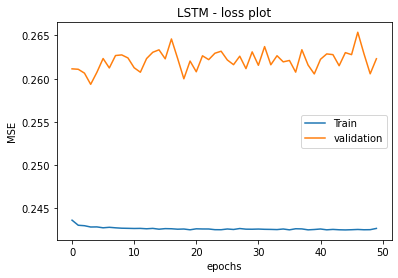

In [ ]:
eps = np.arange(0,n_epochs)
plt.plot(eps, SD_Lstm_model_history.history['loss'])
plt.plot(eps, SD_Lstm_model_history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('MSE')
plt.title('LSTM - loss plot')
plt.legend(['Train', 'validation'])

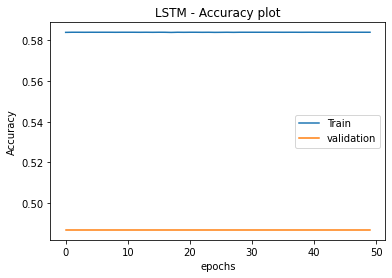

In [ ]:
eps = np.arange(0,n_epochs)
plt.plot(eps, SD_Lstm_model_history.history['accuracy'])
plt.plot(eps, SD_Lstm_model_history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.title('LSTM - Accuracy plot')
plt.legend(['Train', 'validation'])

In [ ]:
#Function to recover clean audio from input in  time domain after running through the trained NN
def speech_recovery(s_data):
  X1 = s_data
  X_abs = np.abs(X1)
  
  X_abs = np.reshape(X_abs, (1,X_abs.shape[0],X_abs.shape[1]))
  ff = SD_Lstm_model.predict( X_abs)
  #Hadamard product to construct clean test signal
  sbar = ff[0]*X1
  
  #inverse stft to bring the signal to time domain
  s = librosa.core.istft(sbar.T, hop_length=512)
    
  return s

In [ ]:
#Function for calculating SNR
def snr_cal(at_clean_file, spec_sound_file):
  
  s = speech_recovery(spec_sound_file)
  
  min_len = min(len(at_clean_file),len(s))
  pred_clipped = s[:min_len]
  true_clipped = at_clean_file[:min_len]
  
  signal = np.dot(true_clipped.T,true_clipped)
  subtract = true_clipped - pred_clipped
  noise = np.dot(subtract,subtract.T)
  
  snr = 10*np.log10(signal/noise)
  #print('Signal to Noise Ratio for input file:',snr)
  return snr

In [ ]:
snr_cal(val_clean_lists['at_list'][2], val_sound_lists['spec_list'][2])

2.8493493795394897

In [ ]:
snr_vals = []
for i in range(1200):
  snr = snr_cal(val_clean_lists['at_list'][i], val_sound_lists['spec_list'][i])
  #print(snr)
  snr_vals.append(snr)
  
print('Average SNR:',np.mean(snr_vals))

Average SNR: 2.8097452675923704


In [ ]:
#Storing the feed forward Test files
for i in range(len(test_sound_lists['at_list'])):
  test_ff = speech_recovery(test_sound_lists['spec_list'][i])
  op_file_name = 'test_s_'+str(i)+'_recons.wav'
  sf.write(dirpath+op_file_name, test_ff, 16000)